In [28]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import VFDstuff as VFD
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from copy import copy as cp
import matplotlib.path as mpltPath
import scipy.interpolate as interp

In [29]:
%matplotlib notebook
fontsize = 14
color = 'k'
linewidth = 4
markersize = 10
margin = 0.2

# Units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
angle_unit = 'radian'

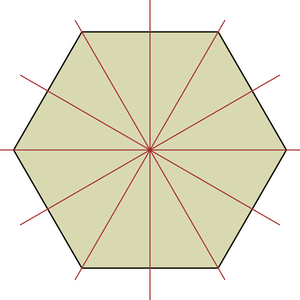

In [30]:
# Defining properties of the crystal and the box it's in

# Some key parameters
L = AssignQuantity(30,distance_unit)
npts_theta = 16
npts_theta_box = npts_theta*6
npts_r = 100
npts_r_box = npts_r
r_far_field = L*1.2

# if np.mod(npts_theta,2) != 0:
#     npts_theta += 1
itheta_middle = np.rint(npts_theta/2).astype('int'); #print(itheta_middle)
left_partner = [True]
for itheta in range(1,itheta_middle+1):
    left_partner.append(False)
for itheta in range(itheta_middle+2,npts_theta+1):
    left_partner.append(True)
left_partner = left_partner * 6; 

right_partner = []
for itheta in range(itheta_middle):
    right_partner.append(True)
for itheta in range(itheta_middle+1,npts_theta+1):
    right_partner.append(False)
right_partner = right_partner * 6

# print('\n left partners:')
# for i in range(len(left_partner)):
#     if np.mod(i,npts_theta) == 0:
#         print('')
#     print(i,left_partner[i])

# print('\n right partners:')
# for i in range(len(right_partner)):
#     if np.mod(i,npts_theta) == 0:
#         print('')
#     print(i,right_partner[i])


<IPython.core.display.Javascript object>


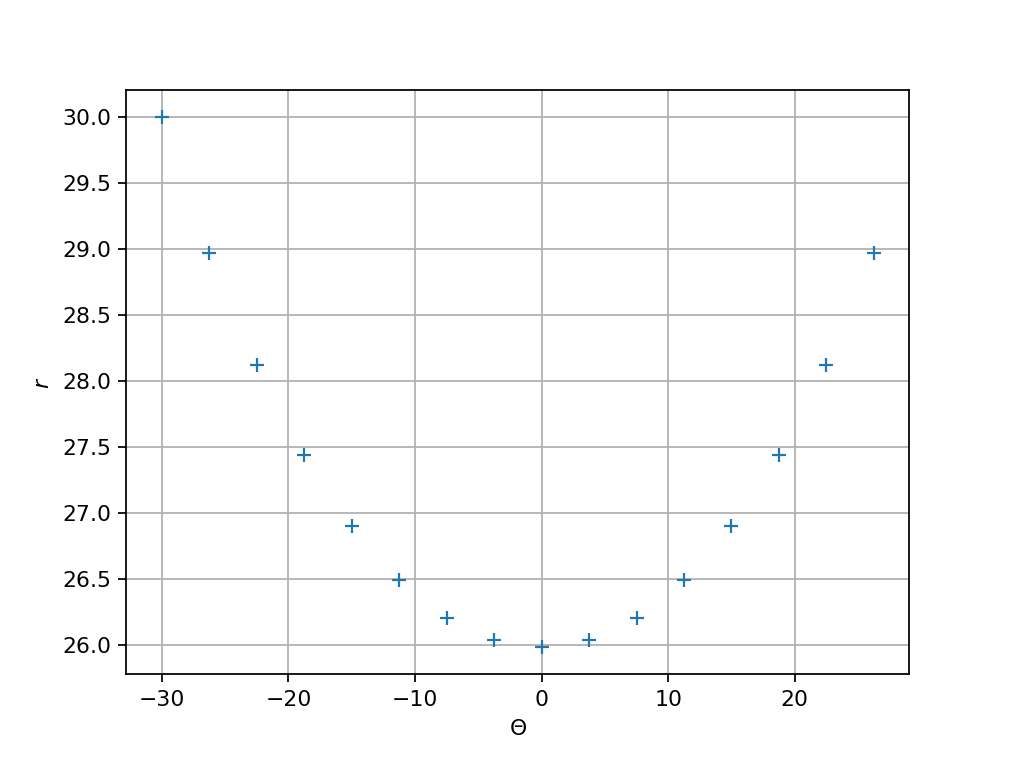

<IPython.core.display.Javascript object>


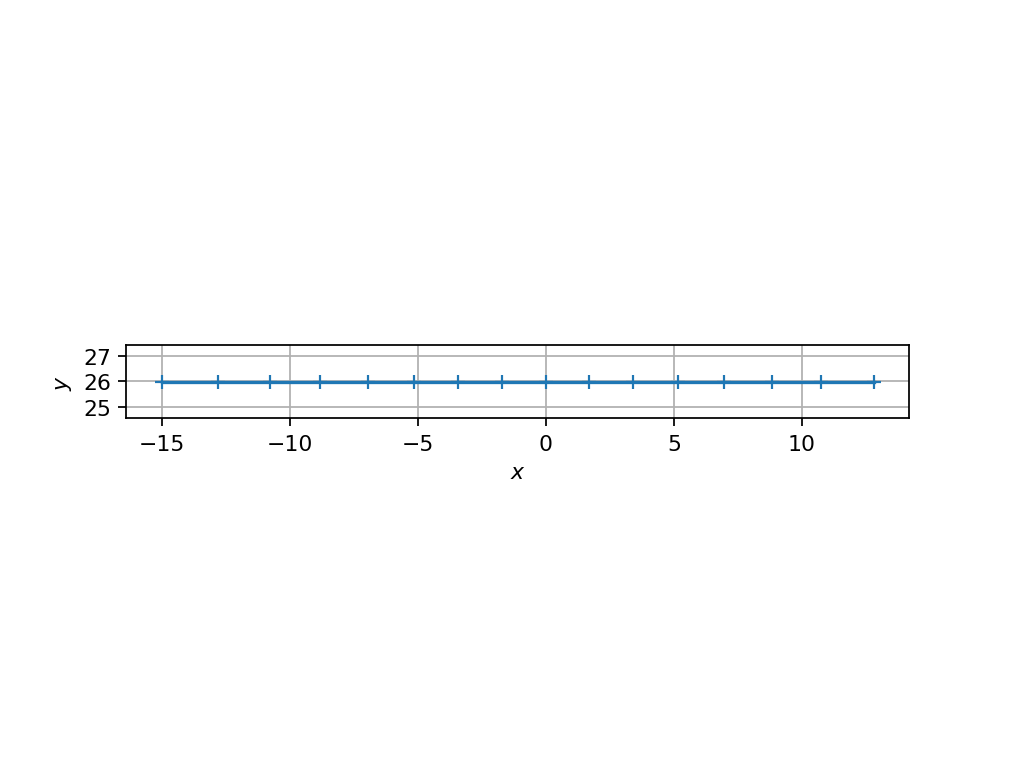

<IPython.core.display.Javascript object>


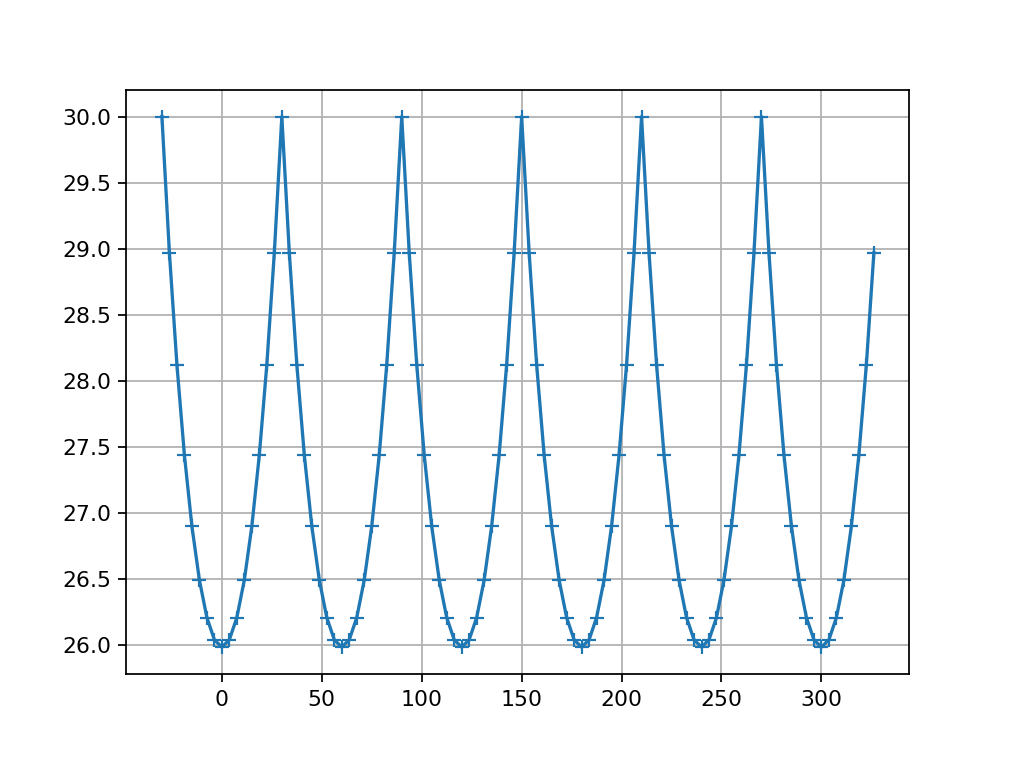

(96,)
(96,)


In [31]:
# Making the crystal

# Make the top edge of the crystal
angle = AssignQuantity(30, 'degree')
angle.ito(angle_unit)
y0 =L*np.cos(angle)
edge0_theta_complete = np.linspace(-angle,angle,npts_theta+1)
edge0_theta = edge0_theta_complete[0:-1]
dtheta = edge0_theta[1]-edge0_theta[0]
edge0_r = y0/np.cos(edge0_theta)
fig, ax = plt.subplots()
plt.plot(edge0_theta.to('degree'),edge0_r,'+')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')
plt.grid(True)

# Convert to Cartesian to make sure this is a straight line at the right place
edge0_x = edge0_r*np.sin(edge0_theta)
edge0_y = edge0_r*np.cos(edge0_theta)
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(edge0_x,edge0_y,'+-')
plt.grid(True)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid(True)

# Gather all the edges together as one big array
edges_theta = np.hstack([\
        edge0_theta,
        edge0_theta+2*angle,
        edge0_theta+4*angle,
        edge0_theta+6*angle,
        edge0_theta+8*angle,
        edge0_theta+10*angle])
edges_r = np.hstack([\
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r,
        edge0_r])
edges_r = AssignQuantity(edges_r,distance_unit)
edges_theta = AssignQuantity(edges_theta,angle_unit)
fig, ax = plt.subplots()
print(np.shape(edges_theta.to('degree').magnitude))
print(np.shape(edges_r.magnitude))
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'+-')
plt.grid(True)
npts_edge = len(edges_r)

36.0 micrometer
dr = 0.1012044230956235 micrometer


<IPython.core.display.Javascript object>


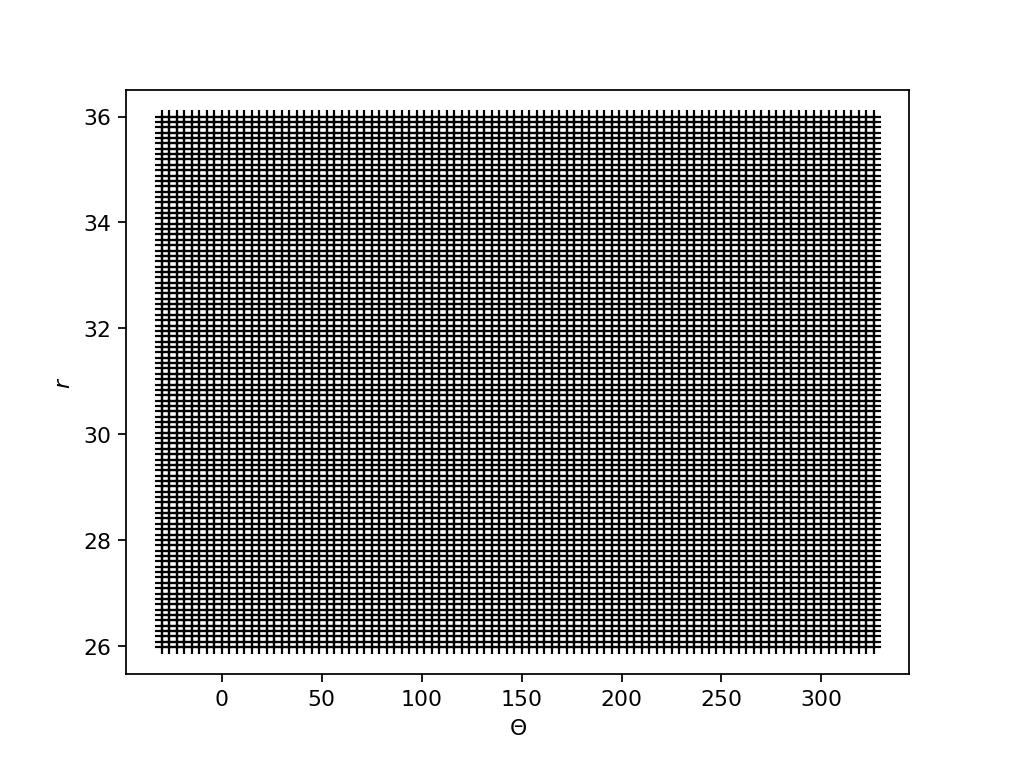

(96, 100)
(96, 100)


<IPython.core.display.Javascript object>


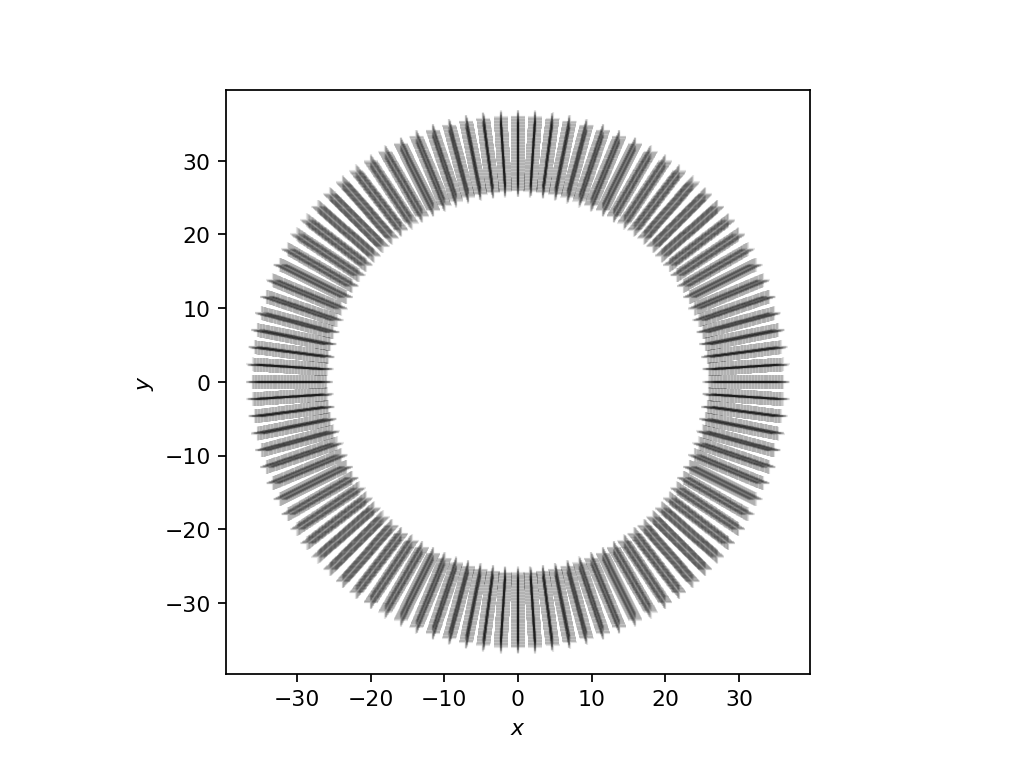

Text(0, 0.5, '$y$')

In [44]:
# Making a discretized box to put the crystal into (we'll use the crystal's angles)
rmin = np.min(edges_r); #print(rmin)
rmax = r_far_field; print(rmax)
array_r = np.linspace(rmin,rmax,npts_r)
dr = array_r[1]-array_r[0]; print('dr =', dr)
array_theta = edges_theta
grid_r, grid_theta = np.meshgrid(array_r.magnitude,array_theta.magnitude)
grid_r = AssignQuantity(grid_r,distance_unit)
grid_theta = AssignQuantity(grid_theta,angle_unit)
plt.figure()
plt.plot(grid_theta.to('degree').magnitude,grid_r.magnitude,'+k')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

# Converting to Cartesian to see what this looks like
grid_x = grid_r*np.sin(grid_theta); print(np.shape(grid_x))
grid_y = grid_r*np.cos(grid_theta); print(np.shape(grid_y))
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(grid_x.magnitude,grid_y.magnitude,'+k',alpha=0.1)
plt.xlabel('$x$')
plt.ylabel('$y$')

In [33]:
# Physical parameters

# Ice density and other constants
rho_ice = AssignQuantity(0.9,'g/cm^3')
Mvap = AssignQuantity(18,'g/mol')
R = AssignQuantity(8.314,'J/mol/kelvin')

# Setting ice parameters
sigma0 = 0.2
print('sigma0 = ',sigma0)

# The far-field supersaturation
sigmaI_far_field = 0.25

# Temperature and pressure
Temp = AssignQuantity(240,'kelvin')
Pressure = AssignQuantity(50,'pascal')

# Converting to the desired pressure unit
Pressure.ito(pressure_unit)
print('Pressure = ', Pressure)
print('Temperature = ',Temp)

# Checking on the plausibility of this growth rate
nu_kin = VFD.get_nu_kin(Temp,AssignQuantity)
print('g_ice should be smaller than sigmaI_far_field x nu_kin ...')
print('nu_kin = ', nu_kin)
print('sigmaI_far_field x nu_kin = ', sigmaI_far_field*nu_kin)

# Compute diffusion coefficient of water through air at this temperature
# This is using trends from engineering toolbox, with the log-log correction
D = VFD.getDofTP(Temp,Pressure,AssignQuantity); print('D = ', D)

sigma0 =  0.2
Pressure =  50 pascal
Temperature =  240 kelvin
g_ice should be smaller than sigmaI_far_field x nu_kin ...
nu_kin =  39.341788071548116 micrometer / second
sigmaI_far_field x nu_kin =  9.835447017887029 micrometer / second
D0 =  21.893732126411837
D =  34908.31943863489 micrometer ** 2 / microsecond


### Asymmetrical growth rate theory

It's convenient to specify the growth asymmetry as a sinusoidal function, parameterized by $r_g$, defined as the ratio of the growth rate at the bottom facet to that at the top facet (actually, the center of these facets). The result is

$$
g(\theta) = g_o \times (1 + ({1 \over 2} (1-r_g) (cos(\theta)-1))
$$

g_ice_0 1 micrometer / second


<IPython.core.display.Javascript object>


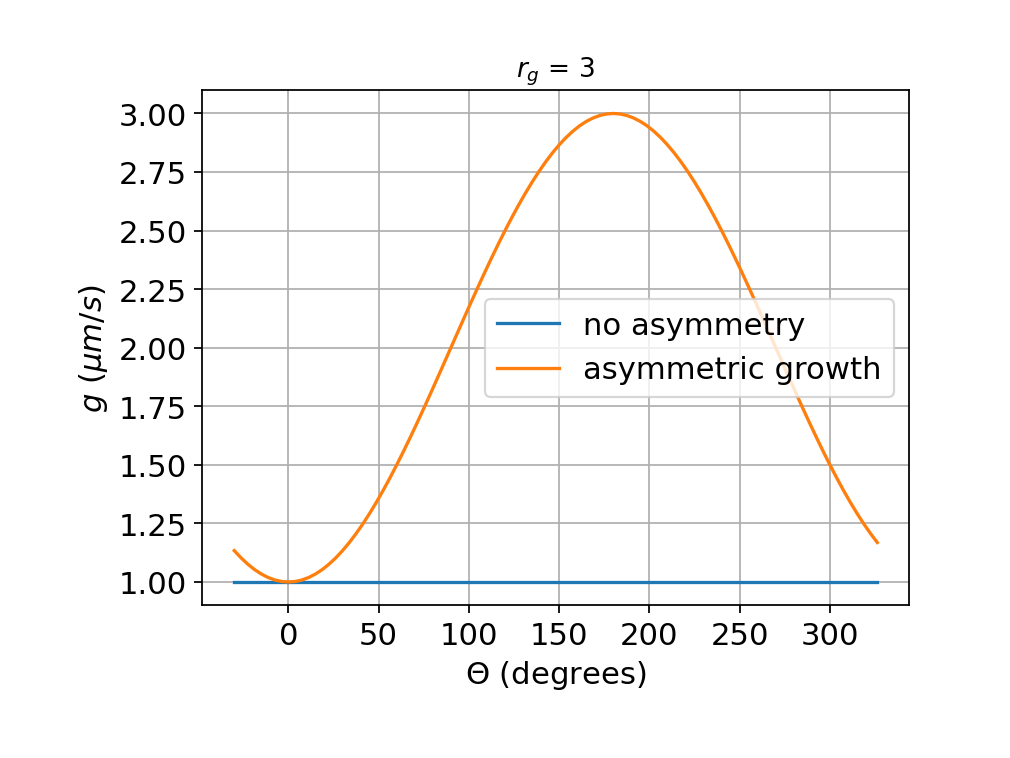

Text(0.5, 1.0, '$r_g$ = 3')

In [46]:
g_ice_0 = AssignQuantity(1,'micrometer/second')
print('g_ice_0',g_ice_0)

# Parameterizing the asymmetry
g_asymmetry_ratio = 3 # growth rate at bottom / growth rate at top
    
# For reference
g_ice_0_array = g_ice_0*np.ones(np.shape(array_theta))

# Sinusoidal
I_want_sinusoidal = True
if I_want_sinusoidal:
    g_ice = g_ice_0*(1 + (1-g_asymmetry_ratio)/2*(np.cos(array_theta) -1))
else:
    g_ice = g_ice_0_array
    g_ice[3*npts_theta:4*npts_theta] = g_ice_0*g_asymmetry_ratio

plt.figure()
plt.plot(edges_theta.to('degree').magnitude,g_ice_0_array.magnitude,label='no asymmetry')
plt.plot(edges_theta.to('degree').magnitude,g_ice.magnitude,label='asymmetric growth')
plt.grid(True)
plt.xlabel('$\Theta$ (degrees)',fontsize=fontsize)
plt.ylabel('$g \ (μm/s)$',fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.subplots_adjust(left=margin)
plt.legend(fontsize=fontsize)
plt.title('$r_g$ = '+str(g_asymmetry_ratio))

In [35]:
# Time step, boundary conditions, etc.

# Getting a suitable time step
dt = dr**2/D/3; print('dt = ', dt)

# Computing effective diffusion coefficents - which should be dimensionless
D_times_dt = D*dt; print('D_times_dt = ', D_times_dt)
Dreff1 = (D_times_dt / dr)
Dreff2 = (D_times_dt / dr**2)
Dteff2 = (D_times_dt / dtheta**2)

# kappa (need to check if this is right)
kappa = rho_ice*g_ice*R*Temp/(Mvap*dr); kappa.ito(pressure_unit+'/'+time_unit)
# print('kappa',kappa)

# Neumann
uneumann = kappa*dt; #print('uneumann',uneumann)
uneumann_mag = uneumann.magnitude

# Calculating the dirichlet conditions at the far-field boundary
sigmaII_far_field = sigmaI_far_field - sigma0
print('sigmaI_far_field = ', sigmaI_far_field)
print('sigmaII_far_field = ', sigmaII_far_field)

# Converting this into pressures
P3 = AssignQuantity(611,'Pa')
T3 = AssignQuantity(273,'kelvin')
Delta_H_sub = AssignQuantity(50,'kJ/mol')
P_vapor_eq = P3*np.exp(-Delta_H_sub/R*(1/Temp-1/T3)); print('Equilibrium vapor pressure at this temperature = ', P_vapor_eq)
udirichlet = P_vapor_eq*(sigmaI_far_field+1)
print('udirichlet = ', udirichlet)

# Making dimensionless variables for efficiency
udirichlet_mag = udirichlet.magnitude

dt =  9.780223758334462e-08 microsecond
D_times_dt =  0.003414111751372657 micrometer ** 2
sigmaI_far_field =  0.25
sigmaII_far_field =  0.04999999999999999
Equilibrium vapor pressure at this temperature =  29.55023347583504 pascal
udirichlet =  36.9377918447938 pascal


In [36]:
# Index <--> position interconversion functions
def r_to_ir(r,array_r):
    dr = array_r[1]-array_r[0]
    ir = np.rint((r-array_r[0])/dr).astype(int)
    return ir
r_test = AssignQuantity(107, distance_unit)
ir_test = r_to_ir(r_test, array_r)
print(ir_test)

def ir_to_r(ir_test,array_r):
    dr = array_r[1]-array_r[0]
    r = ir_test*dr+array_r[0]
    return r
r_test2 = ir_to_r(ir_test, array_r)
print('r_test2', r_test2)
print('r Differences ... ', r_test2-r_test)

def theta_to_itheta(theta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    itheta = np.rint((theta-array_theta[0])/dtheta).astype(int)
    return itheta
theta_test = AssignQuantity(-32, 'degree')
itheta_test = theta_to_itheta(theta_test.to(angle_unit), array_theta)
print(itheta_test)

def itheta_to_theta(itheta, array_theta):
    dtheta = array_theta[1]-array_theta[0]
    theta = itheta*dtheta+array_theta[0]
    return(theta)
theta_test2 = itheta_to_theta(itheta_test, array_theta)
print('theta_test2', theta_test2)
print('theta Differences ... ', theta_test2-theta_test)

801 dimensionless
r_test2 107.04550501312758 micrometer
r Differences ...  0.04550501312758115 micrometer
-1 dimensionless
theta_test2 -0.5890486225480862 radian
theta Differences ...  -0.030543261909900754 radian


40 dimensionless


<IPython.core.display.Javascript object>


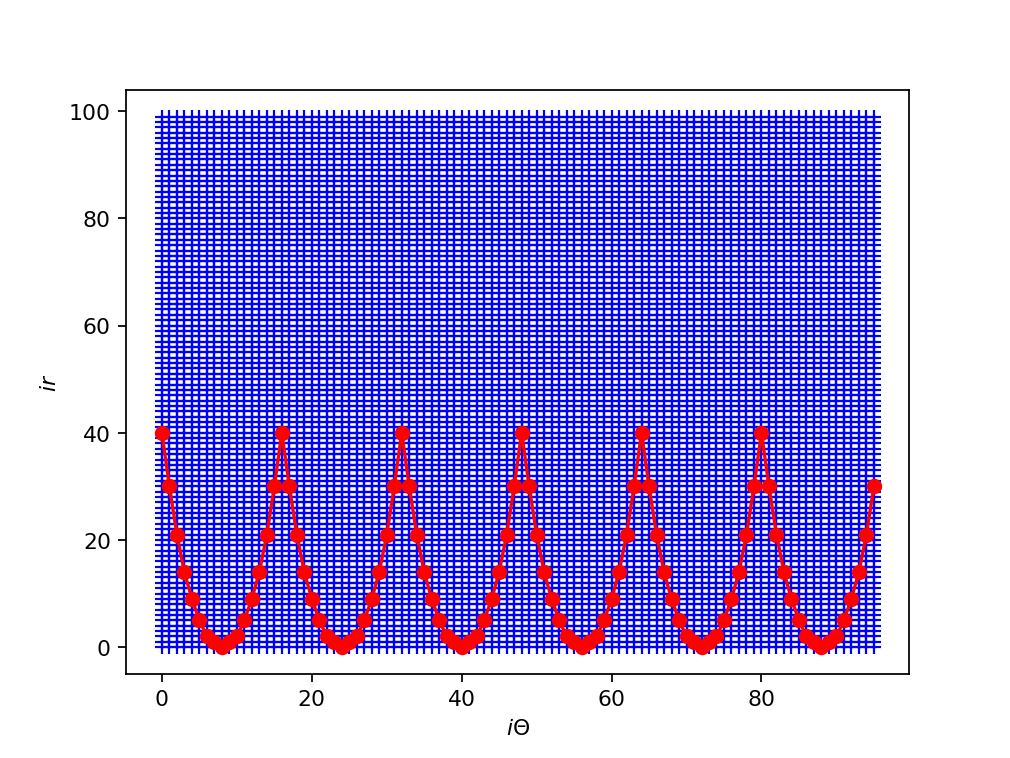

<IPython.core.display.Javascript object>


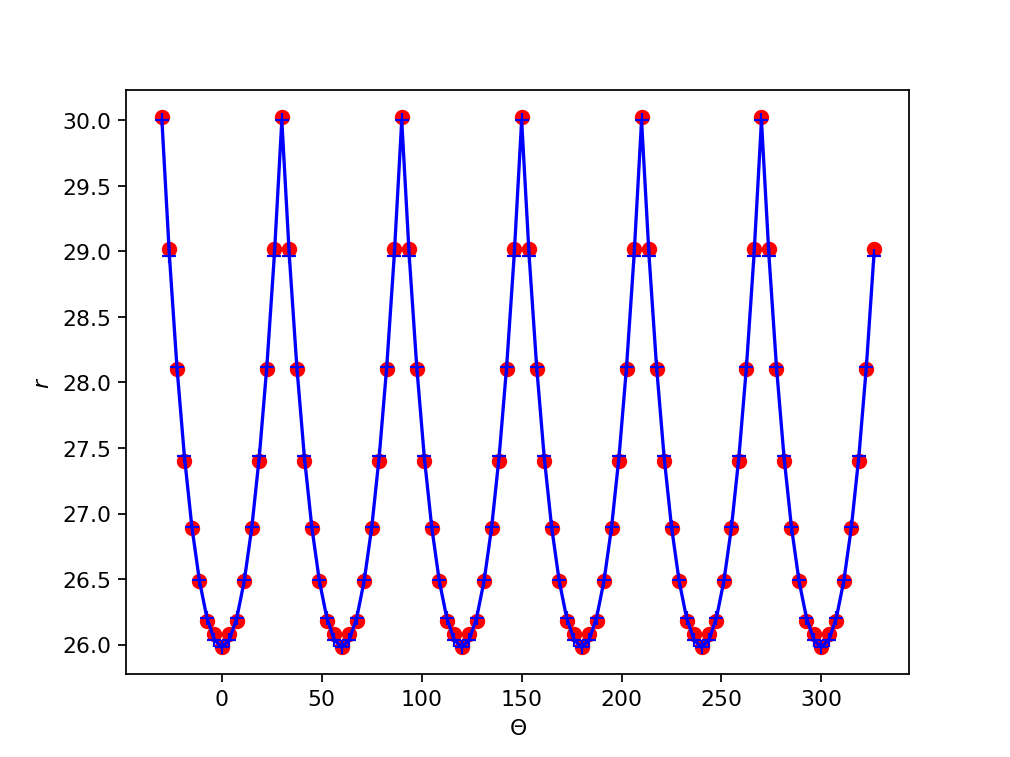

Text(0, 0.5, '$r$')

In [37]:
# Plotting the crystal edge in index space
edges_ir = r_to_ir(edges_r,array_r)
edges_itheta = theta_to_itheta(edges_theta, array_theta)
edges_ir_max = np.max(edges_ir); print(edges_ir_max)

igrid_r = r_to_ir(grid_r,array_r)
igrid_theta = theta_to_itheta(grid_theta, array_theta)

plt.figure()
plt.plot(igrid_theta,igrid_r,'+b')
plt.plot(edges_itheta.magnitude,edges_ir.magnitude,'ro-')
plt.xlabel('$i\Theta$')
plt.ylabel('$ir$')

edges_r2 = ir_to_r(edges_ir, array_r)
edges_theta2 = itheta_to_theta(edges_itheta, array_theta)

plt.figure()
plt.plot(edges_theta2.to('degree'),edges_r2,'ro')
plt.plot(edges_theta.to('degree').magnitude,edges_r.magnitude,'b+-')
plt.xlabel('$\Theta$')
plt.ylabel('$r$')

In [38]:
def Polar_propagate_hexagon(u0, udirichlet, uneumann, \
                            Dreff1, Dreff2, Dteff2, \
                            edges_r, edges_ir, \
                            array_r, left_partner, right_partner):

    # Propagates the vapor field forward one time step
    
    # Initialize starting values (all should be overwritten or ignored)
#     un = np.ones(np.shape(u0))
    un = np.zeros(np.shape(u0))
    un_angular_diffusion = np.ones(np.shape(u0))
    npts_edge = len(edges_r)

    # Looping over angles
    for itheta in range(npts_edge):
        
        # Radial indices for the surface-adjacent layer (ir) and two farther out
        ir = edges_ir[itheta]
        ir_plus1 = ir+1
        ir_plus2 = ir+2
                
        # Previous state + radial diffusion one layer above the surface-adjacent layer, out to the far field
        un[itheta,ir_plus1:-1] = u0[itheta,ir_plus1:-1] +\
            (u0[itheta,ir_plus2:] - 2*u0[itheta,ir_plus1:-1] +u0[itheta,ir:-2])*Dreff2 +\
            (u0[itheta,ir_plus2:]   - u0[itheta,ir_plus1:-1])                  *Dreff1/array_r[ir_plus1:-1]
        
        # Previous state + radial diffusion for the surface-adjacent layer 
        un[itheta,ir] = u0[itheta,ir] +\
            (u0[itheta,ir_plus1] - u0[itheta,ir])*Dreff2 +\
            (u0[itheta,ir_plus1] - u0[itheta,ir])*Dreff1/array_r[ir]
        
        # Neumann conditions at the surface-adjacent layer
        un[itheta,ir] -= uneumann[itheta] *edges_r[0]/edges_r[itheta]

        # Prep for angular diffusion: nearby theta indices, periodic boundary indices
        itheta_minus1 = itheta-1
        itheta_plus1 = itheta+1
        if itheta_plus1 == npts_edge:
            itheta_plus1 = 0        
        
        # Assume two-directional angular diffusion at all r-values (some will be overwritten)
        un_angular_diffusion[itheta,:] = \
            (u0[itheta_minus1,:] -2*u0[itheta,:] +u0[itheta_plus1,:] ) *Dteff2/array_r**2
        
        # Zero out in-crystal diffusion
        un_angular_diffusion[itheta,0:ir] = 0
        
        # Find the nearest angular neighbor that is higher than this one 
        if left_partner[itheta] == False and right_partner[itheta] == True: # Sloping down, or 1st of several bottom pixels 
            ir_up = edges_ir[itheta_minus1]
            un_angular_diffusion[itheta,ir:ir_up] = (u0[itheta_plus1,ir:ir_up] - u0[itheta,ir:ir_up]) \
                *Dteff2/array_r[ir:ir_up]**2
        if left_partner[itheta] == True and right_partner[itheta] == False: # Sloping up, or last of several bottom pixels 
            ir_up = edges_ir[itheta_plus1]
            un_angular_diffusion[itheta,ir:ir_up] = (u0[itheta_minus1,ir:ir_up] - u0[itheta,ir:ir_up]) \
                *Dteff2/array_r[ir:ir_up]**2
        elif left_partner[itheta] == False and right_partner[itheta] == False: # Solitary bottom pixel
            un_angular_diffusion[itheta,ir] = 0
            
        # Zeroing out the crystal values (cosmetic, since we don't use at these values)
            un[itheta,0:ir] = 0

        # Assigning Dirichlet conditions at the far-field limit
        un[itheta,-1] = udirichlet
    
    # Add in the angular diffusion
    un += un_angular_diffusion

    return(un)

In [39]:
# Decide on a time to propagate forward
tmax = AssignQuantity(.01,time_unit)
ntimes = int(tmax/dt)
print('Integrating steps = ', ntimes)
print('Integrating out to ', ntimes*dt) # This is a check -- it should be very close to the tmax specified above
print('g_ice at facet corner =',g_ice[0])
print('g_ice at facet center =',g_ice[itheta_middle])

# Propagate forward in time
un = np.ones(np.shape(igrid_r))*udirichlet.magnitude
for i in range(ntimes):
    un = Polar_propagate_hexagon(\
        un, udirichlet.magnitude, uneumann.magnitude, \
        Dreff1.magnitude, Dreff2.magnitude, Dteff2.magnitude/1, \
        edges_r.magnitude, edges_ir.magnitude, \
        array_r.magnitude, left_partner, right_partner)

Integrating steps =  102247
Integrating out to  0.009999985386184237 microsecond
g_ice at facet corner = 1.1339745962155612 micrometer / second
g_ice at facet center = 1.0 micrometer / second


0
40


<IPython.core.display.Javascript object>


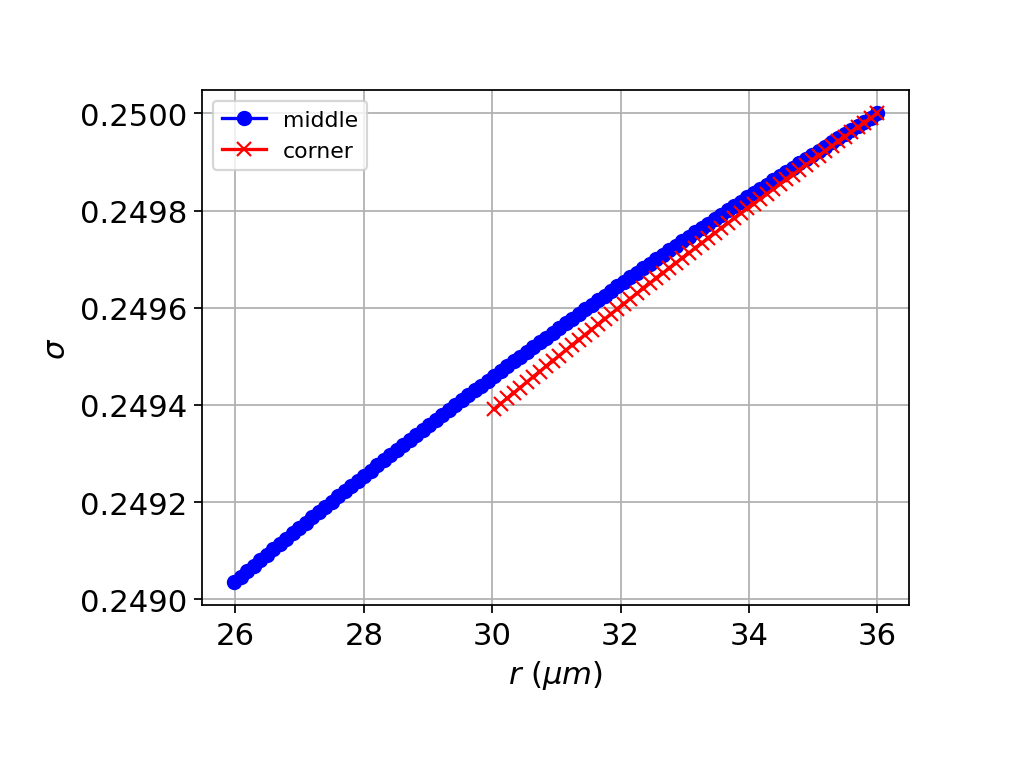

<IPython.core.display.Javascript object>


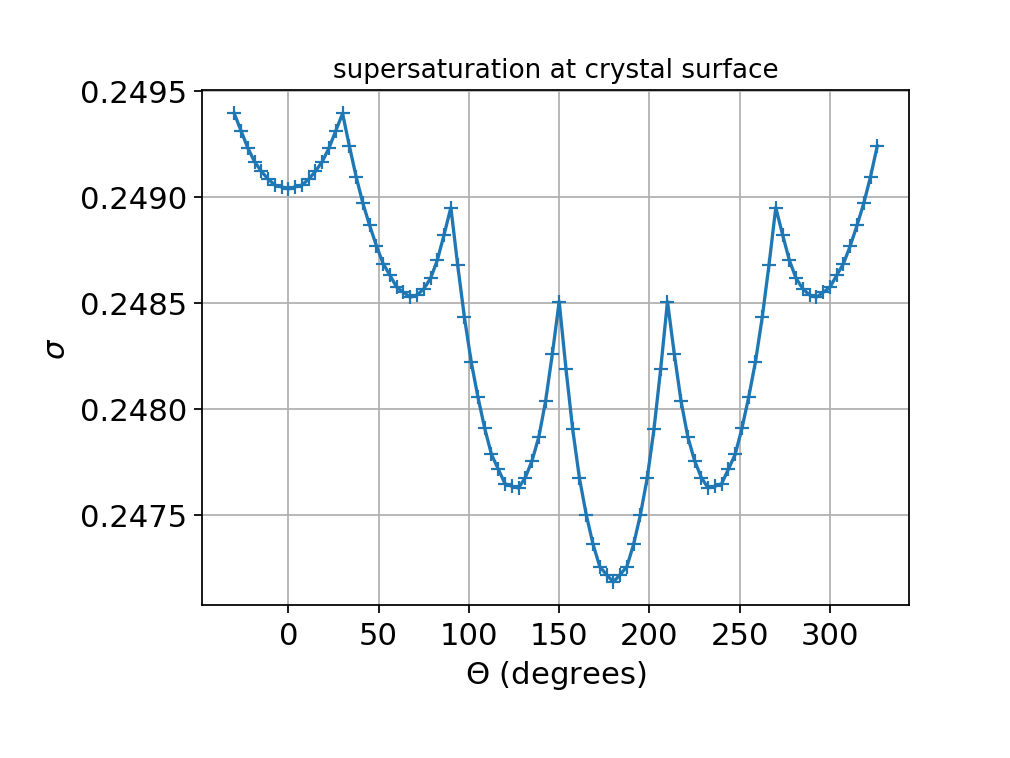

sigma1 0.24903597450216597
sigma2 0.25


<IPython.core.display.Javascript object>


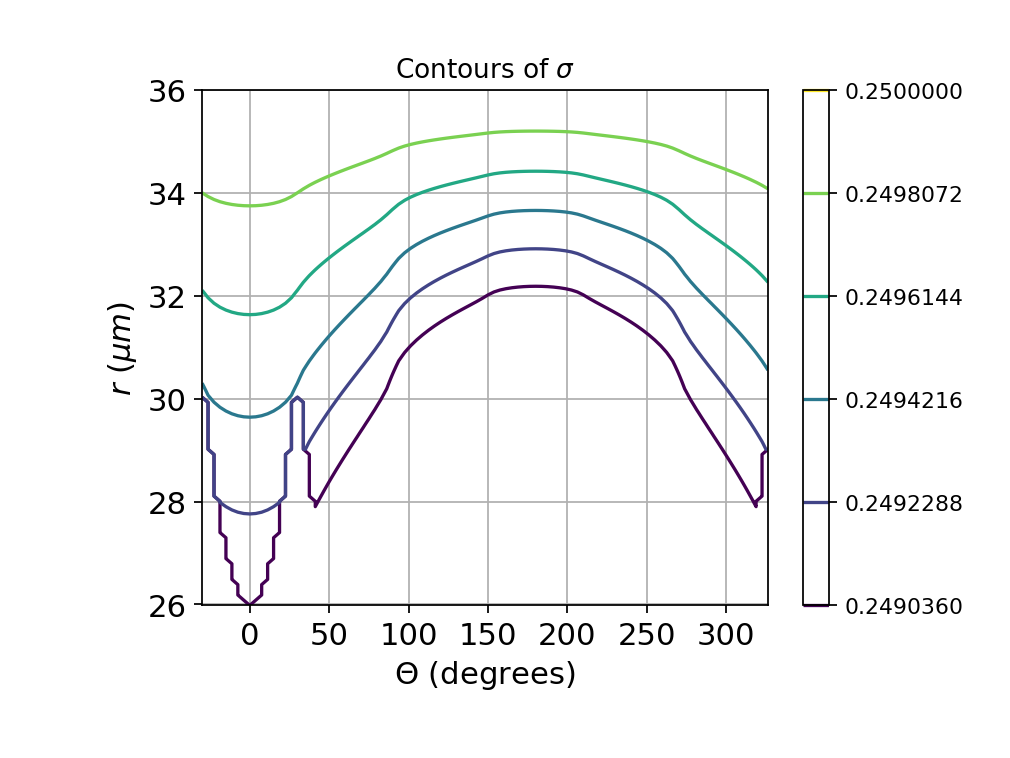

<IPython.core.display.Javascript object>


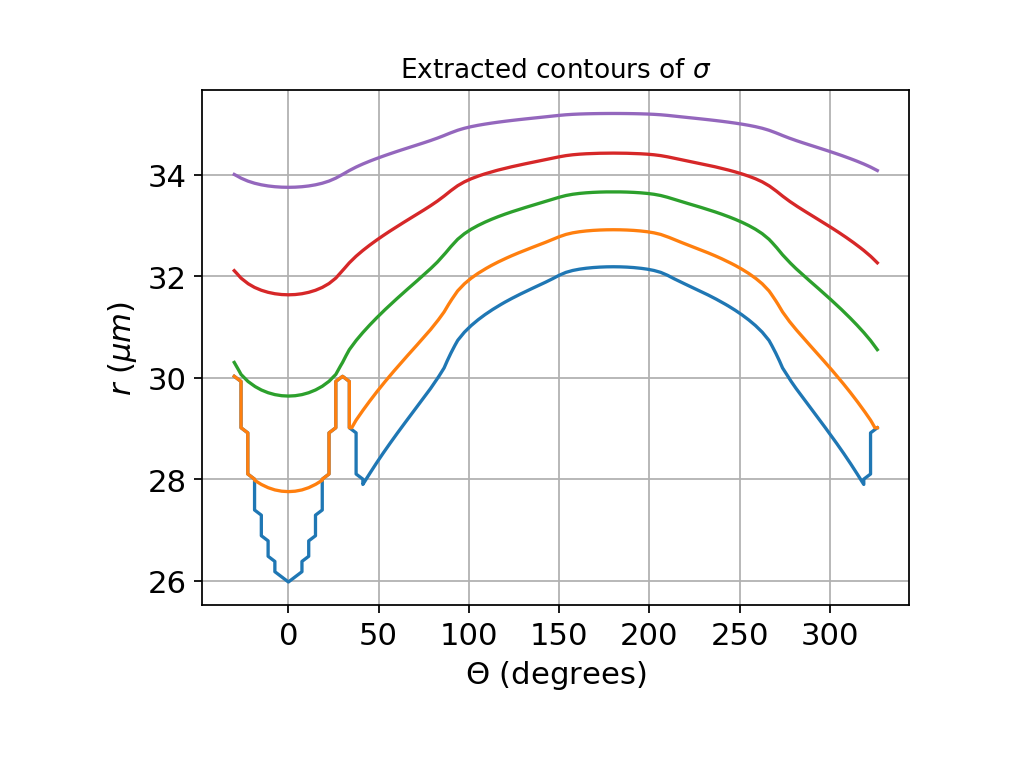

In [47]:
# Graphic investigation of the results

# As a function of r (starting at the adjacent surface, for an angle in the middle of the 1st facet)
ir_middle = edges_ir[itheta_middle].magnitude; print(ir_middle)
sigma_radial_middle = (un[itheta_middle,ir_middle:]/P_vapor_eq.magnitude-1)
ir_0 = edges_ir[0].magnitude; print(ir_0)
sigma_radial_0 = (un[0,ir_0:]/P_vapor_eq.magnitude-1)
plt.figure()
plt.plot(array_r[ir_middle:],sigma_radial_middle,'o-b',label='middle')
plt.plot(array_r[ir_0:],sigma_radial_0,'x-r',label='corner')
plt.xlabel('$r$ ($\mu m$)', fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 
plt.ylabel('$\sigma$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(True)
plt.legend()

# As a function of angle at the adjacent surface (ir)
sigma_edge = np.zeros(npts_edge)
for itheta in range(npts_edge):
    ir = edges_ir[itheta].magnitude
    sigma_edge[itheta] = (un[itheta,ir]/P_vapor_eq.magnitude-1)
plt.figure()
plt.plot(array_theta.to('degree').magnitude,sigma_edge,'+-')
plt.xlabel('$\Theta$ (degrees)', fontsize=fontsize)
plt.ylabel('$\sigma$', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin) 
plt.subplots_adjust(left=margin) 
plt.grid(True)
plt.title('supersaturation at crystal surface')

# As a contour plot in {theta,r} space
sigma_grid = (un/P_vapor_eq.magnitude-1)
sigma1 = sigma_grid[itheta_middle,ir_middle]; print('sigma1',sigma1)
sigma2 = sigmaI_far_field; print('sigma2',sigma2)
nlevels = 6
levels = np.linspace(sigma1,sigma2,nlevels)
fig,ax = plt.subplots()
CS_polar = ax.contour(array_theta.to('degree').magnitude,array_r.magnitude,sigma_grid.T,levels)
ax.set_xlabel('$\Theta$ (degrees)', fontsize=fontsize)
ax.set_ylabel('$r$ ($\mu m$)', fontsize=fontsize)
ax.set_title('Contours of $\sigma$')
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.subplots_adjust(left=margin)
plt.grid(True)
fig.colorbar(CS_polar)

# Plot contours "extracted" using .collections (to be sure it agrees with the above)
fig,ax = plt.subplots()
for i in range(nlevels-1):
    contour_theta = CS_polar.collections[i].get_paths()[0].vertices[:,0]; #print(np.shape(contour_x))
    contour_r = CS_polar.collections[i].get_paths()[0].vertices[:,1]; #print(np.shape(contour_y))
    plt.plot(contour_theta,contour_r)
ax.set_xlabel('$\Theta$ (degrees)', fontsize=fontsize)
ax.set_ylabel('$r$ ($\mu m$)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.subplots_adjust(left=margin)
ax.set_title('Extracted contours of $\sigma$')
plt.grid(True)

<IPython.core.display.Javascript object>


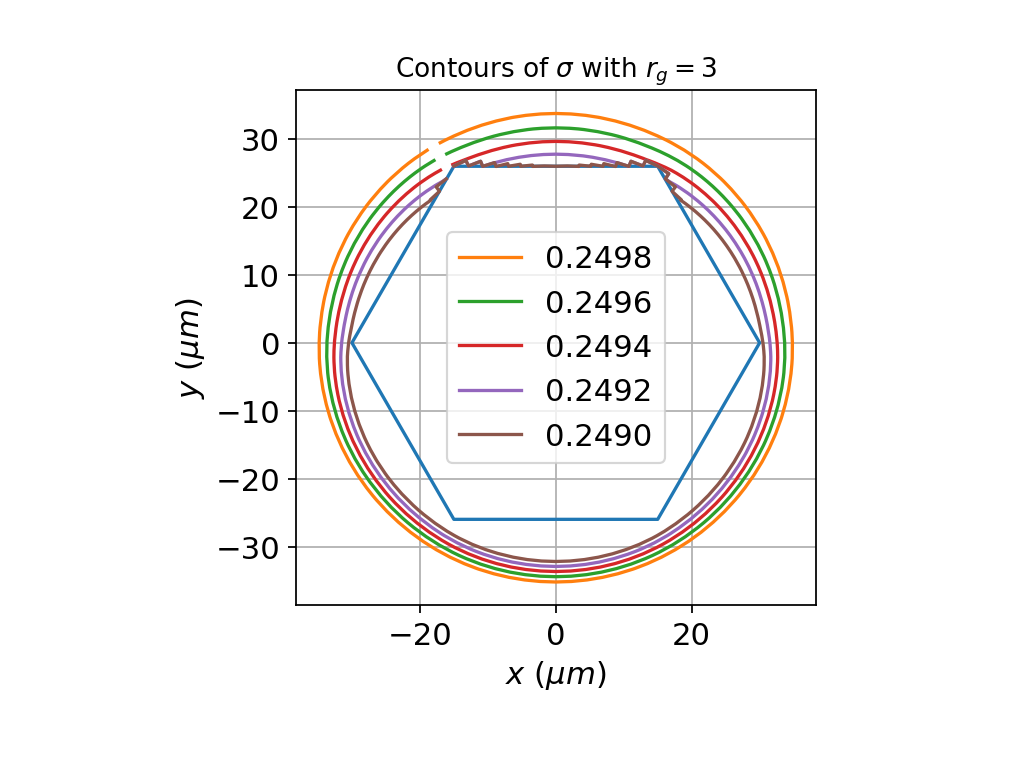

In [48]:
# Plotting supersaturation contours from polar space, transformed to Cartesian space
edges_x = (edges_r*np.sin(edges_theta)).magnitude
edges_y = (edges_r*np.cos(edges_theta)).magnitude

fig, ax = plt.subplots()
ax.set_aspect('equal')
edges_x_complete = np.append(edges_x,edges_x[0])
edges_y_complete = np.append(edges_y,edges_y[0])
plt.plot(edges_x_complete,edges_y_complete)

for i in range(nlevels-2,-1,-1):
    contour_theta_degrees = CS_polar.collections[i].get_paths()[0].vertices[:,0]
    contour_theta = contour_theta_degrees*np.pi/180
    contour_r = CS_polar.collections[i].get_paths()[0].vertices[:,1]; #print(np.shape(contour_y))
    contour_x_from_polar = contour_r*np.sin(contour_theta)
    contour_y_from_polar = contour_r*np.cos(contour_theta)
    contour_x_from_polar_complete = np.append(contour_x_from_polar,contour_x_from_polar[0])
    contour_y_from_polar_complete = np.append(contour_y_from_polar,contour_y_from_polar[0])
    label = '%.4f' %  levels[i]
    plt.plot(contour_x_from_polar,contour_y_from_polar,label=label)
    
ax.set_xlabel('$x$ ($\mu m$)', fontsize=fontsize)
ax.set_ylabel('$y$ ($\mu m$)', fontsize=fontsize)
ax.set_title('Contours of $\sigma$ with $r_g=$'+str(g_asymmetry_ratio))
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.subplots_adjust(bottom=margin)
plt.subplots_adjust(left=margin)
plt.legend(fontsize=fontsize)
plt.grid(True)

In [42]:
# The center reduction; results are not symmetrical because of the ambiguity in defining the corner (left vs right)
for i in range(6):
    itheta = i*npts_theta
    ir_corner = edges_ir[itheta].magnitude
    ir_middle = edges_ir[itheta+itheta_middle].magnitude
    c_r = (un[itheta,ir_corner] - un[itheta+itheta_middle,ir_middle])/un[itheta,ir_corner]
    print('i, c_r (%) =', i, c_r*100)

i, c_r (%) = 0 0.0284752620912716
i, c_r (%) = 1 0.06553124734684047
i, c_r (%) = 2 0.10421598443392606
i, c_r (%) = 3 0.10584589233214832
i, c_r (%) = 4 0.06876360520947492
i, c_r (%) = 5 0.03007772138754697


### Conversion to a Cartesian grid
See https://stackoverflow.com/questions/37872171/how-can-i-perform-two-dimensional-interpolation-using-scipy). But this didn't work well because its extrapolation was no good.

In [43]:
# # Set up the interpolator "zfun"
# npts_in_polar_grid = npts_theta_box*npts_r_box

# x_from_polar = np.reshape(grid_x.magnitude,npts_in_polar_grid)
# print(np.shape(x_from_polar))
# print(x_from_polar[0])

# y_from_polar = np.reshape(grid_y.magnitude,npts_in_polar_grid)
# print(np.shape(y_from_polar))
# print(y_from_polar[0])

# xypoints = np.stack((x_from_polar,y_from_polar),-1)
# print(np.shape(xypoints))
# print(xypoints[0,:])

# un_from_polar = np.reshape(un,npts_in_polar_grid)
# print(np.shape(un_from_polar))
# print(un[0,0])
# print(un_from_polar[0])

# zfun = interp.RBFInterpolator(xypoints,un_from_polar,
#                               smoothing=0, kernel='cubic')

# # Define a new uniform Cartesian grid to interpolate to
# efactor = 1.1
# npts_x_new = 80; array_x_new = np.linspace(-r_far_field.magnitude*efactor,r_far_field.magnitude*efactor,npts_x_new)
# npts_y_new = 81; array_y_new = np.linspace(-r_far_field.magnitude*efactor,r_far_field.magnitude*efactor,npts_y_new)
# npts_in_new_Cartesian_grid = npts_x_new*npts_y_new; print(npts_in_new_Cartesian_grid)
# grid_y_new,grid_x_new = np.meshgrid(array_y_new,array_x_new)
# print(np.shape(grid_x_new))
# print(grid_x_new[0:5,0])
# print(grid_y_new[0:5,0])
# print(grid_x_new[0,0:5])
# print(grid_y_new[0,0:5])
# x_new = np.reshape(grid_x_new,npts_in_new_Cartesian_grid)
# print(np.shape(x_new))
# y_new = np.reshape(grid_y_new,npts_in_new_Cartesian_grid)
# print(np.shape(y_new))
# xypoints_new = np.stack((x_new,y_new),-1)
# print(np.shape(xypoints_new))
# print(xypoints_new[0,:])

# # Interpolate
# un_on_uniform_xygrid = zfun(xypoints_new)
# np.shape(un_on_uniform_xygrid)

# un_on_uniform_xygrid_reshaped = np.reshape(un_on_uniform_xygrid,(npts_x_new,npts_y_new))
# grid_x_new_test = np.reshape(x_new,(npts_x_new,npts_y_new))
# grid_y_new_test = np.reshape(y_new,(npts_x_new,npts_y_new))

# print(grid_x_new_test[0:5,0])
# print(grid_y_new_test[0:5,0])
# print(grid_x_new_test[0,0:5])
# print(grid_y_new_test[0,0:5])

# sigma_on_uniform_xygrid = (un_on_uniform_xygrid_reshaped/P_vapor_eq.magnitude-1)
# nlevels = 7
# levels = np.linspace(0.24,0.25,nlevels)
# fig,ax = plt.subplots()
# plt.plot(grid_x.magnitude,grid_y.magnitude,'+k', alpha=0.1)
# CS = ax.contourf(grid_x_new_test.T,grid_y_new_test.T,sigma_on_uniform_xygrid.T,levels)
# ax.set_xlabel('$x$', fontsize=fontsize)
# ax.set_ylabel('$y$', fontsize=fontsize)
# ax.set_title('Contours of $\sigma$')
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
# plt.subplots_adjust(bottom=margin)
# plt.subplots_adjust(left=margin)
# ax.set_aspect('equal')
# plt.grid(True)
# fig.colorbar(CS)